In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = False

In [2]:
import sys 
import os
sys.path.append('../')

from BackDiffuse_LT import BackDiffuse

In [3]:
CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

In [4]:
lat = np.array([71.12038,70.30,77.17972,70.63491,70.65081,70.67700,70.63980,71.75926,71.49200,71.15495,70.86510])
lon = np.array([322.68364,315.00000,298.89026,324.18001,322.52121,321.21300,320.38222,324.14947,324.11877,324.16227,324.16187])
elev = np.array([3172,2410,1880,3092,3138,3072,3018,3087,3092,3098,3102])
T10m = -np.array([30.40,22.30,24.29,29.41,29.77,29.07,28.30,30.37,30.42,30.10,29.59])
T20m = -np.array([30.16,0,24.35,29.41,29.48,28.54,27.89,30.41,30.36,30.01,29.53])
coreLength = np.array([404.0,398.0,100.1,128.6,105.6,24.9,100.1,77.8,25.7,70.8,26.2])
drillYr = np.array([1974,1973,1977,1985,1984,1984,1984,1985,1985,1985,1985])

CoresSpecs['lat'] = lat
CoresSpecs['lon'] = lon
CoresSpecs['elev'] = elev
CoresSpecs['T10m'] = T10m
CoresSpecs['T20m'] = T20m
CoresSpecs['coreLength'] = coreLength
CoresSpecs['drillYr'] = drillYr

#print(CoresSpecs.to_latex(index=False))

CoresSpecs2 = CoresSpecs.drop('z0', axis=1)
CoresSpecs2.drop('dens0',axis=1)

CoresSpecs2 = CoresSpecs2[['CoreName','drillYr', 'coreLength', 'lat', 'lon','elev','dLaki', 'dTamb', 'Accum0', 'T0', 'T10m', 'T20m']]
#CoresSpecs2 = CoresSpecs2[[]]
CoresSpecs2.to_csv('/home/thea/MesterTesen/Data/CoreSpecs2.txt', index=None, sep=',')


In [ ]:
def Peaks_v_DiffLen(Site_in):
    CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs2.txt', ',')
    coreNames = CoresSpecs['CoreName']

    site = Site_in
    core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
    CoreSpecs = CoresSpecs.iloc[core_idx]
    dTamb = np.float64(CoreSpecs['dTamb'])
    dLaki = np.float64(CoreSpecs['dLaki'])
    Accum0 = np.float64(CoreSpecs['Accum0'])
    T0 = np.float64(CoreSpecs['T0'])
    dens0 = np.float64(CoreSpecs['dens0'])
    
    
    site_Dens = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDens/'+ site + 'DepthDens_w_Models.txt', '\t')
    site_Diff = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDiff/'+ site + '_DepthDiff.txt', '\t')
    site_ECM = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetECM/'+ site + '_ECM.txt', ',') 
    site_d18O =  pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/Alphabetd18O/'+ site + '_det.txt', ',')
    
            
        # Define density measurements: raw, model and fudged model. Define btw. Laki and Tamb.
    depthRho = site_Dens['depth']
    rhoMeas = site_Dens['rhoMeas']
    HLmodel = site_Dens['HLmodel']
    HLmodelOpti = site_Dens['HLmodelOpti']
    depthRho_LT = depthRho[(depthRho >= dTamb) & (depthRho <= dLaki)]
    rhoMeas_LT = rhoMeas[(depthRho >= dTamb) & (depthRho <= dLaki)]
    HLmodel_LT = HLmodel[(depthRho >= dTamb) & (depthRho <= dLaki)]
    HLmodelOpti_LT =HLmodelOpti[(depthRho >= dTamb) & (depthRho <= dLaki)]

        # Define diffusion length measurements: o18, o17 and D. Define btw. Laki and Tamb.
    depthDiff = site_Diff['Depth']
    sigma_D = site_Diff['sigma_D']
    sigma_o18 = site_Diff['sigma_o18']
    sigma_o17 = site_Diff['sigma_o17']
    depthDiff_LT = depthDiff[(depthDiff >= dTamb) & (depthDiff <= dLaki)]
    sigma_o18_LT = sigma_o18[(depthDiff >= dTamb) & (depthDiff <= dLaki)]
    sigma_o17_LT = sigma_o17[(depthDiff >= dTamb) & (depthDiff <= dLaki)]
    sigma_D_LT = sigma_D[(depthDiff >= dTamb) & (depthDiff <= dLaki)]

        # Define ECM data. Define btw. Laki and Tamb.
    depthECM = site_ECM['depth']
    ECM = site_ECM['ECM']
    depthECM_LT = depthECM[(depthECM >= dTamb) & (depthECM <= dLaki)]
    ECM_LT = ECM[(depthECM >= dTamb) & (depthECM <= dLaki)]

        # Define d18O details data. Define btw. Laki and Tamb.
    depth = site_d18O['depth'][1:]
    d18O = site_d18O['d18O'][1:]
    depth_LT = site_d18O['depth'][(site_d18O['depth'] >= dTamb) & (site_d18O['depth'] <= dLaki)]
    d18O_LT = site_d18O['d18O'][(site_d18O['depth'] >= dTamb) & (site_d18O['depth'] <= dLaki)]

    depth_LT_int, d18O_LT_int, Delta = interpCores(np.asarray(depth_LT)[0], np.asarray(depth_LT)[-1], depth_LT, d18O_LT)
    
    inst = BackDiffuse(site, site_d18O, CoresSpecs, dTamb, dLaki, 500, diffLenData=site_Diff[['Depth','sigma_o18']], densData=site_Dens)
    diffLen = inst.spectralEstimate()
    difflenEstHL = inst.diffLenEstimateHL()
    depth1, data, diffLen, peaks, arr_DiffLens, arr_Npeaks, arr_depth, arr_data = inst.backDiffused(theoDiffLen=False,print_Npeaks=False, diffLenStart_In=0.005, diffLenEnd_In=0.15)

    return

In [6]:
coreNames = CoresSpecs['CoreName']

site = 'SiteA'
core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = np.float64(CoreSpecs['dTamb'])
dLaki = np.float64(CoreSpecs['dLaki'])
Accum0 = np.float64(CoreSpecs['Accum0'])
T0 = np.float64(CoreSpecs['T0'])
dens0 = np.float64(CoreSpecs['dens0'])
z0 = np.float64(CoreSpecs['z0'])


In [7]:
site_Dens = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDens/'+ site + 'DepthDens_w_Models.txt', '\t')
site_Diff = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDiff/'+ site + '_DepthDiff.txt', '\t')
site_ECM = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetECM/'+ site + '_ECM.txt', ',') 
site_d18O =  pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/Alphabetd18O/'+ site + '_det.txt', ',')

In [8]:
    # Define density measurements: raw, model and fudged model. Define btw. Laki and Tamb.
depthRho = site_Dens['depth']
rhoMeas = site_Dens['rhoMeas']
HLmodel = site_Dens['HLmodel']
HLmodelOpti = site_Dens['HLmodelOpti']
depthRho_LT = depthRho[(depthRho >= dTamb) & (depthRho <= dLaki)]
rhoMeas_LT = rhoMeas[(depthRho >= dTamb) & (depthRho <= dLaki)]
HLmodel_LT = HLmodel[(depthRho >= dTamb) & (depthRho <= dLaki)]
HLmodelOpti_LT =HLmodelOpti[(depthRho >= dTamb) & (depthRho <= dLaki)]

    # Define diffusion length measurements: o18, o17 and D. Define btw. Laki and Tamb.
depthDiff = site_Diff['Depth']
sigma_D = site_Diff['sigma_D']
sigma_o18 = site_Diff['sigma_o18']
sigma_o17 = site_Diff['sigma_o17']
depthDiff_LT = depthDiff[(depthDiff >= dTamb) & (depthDiff <= dLaki)]
sigma_o18_LT = sigma_o18[(depthDiff >= dTamb) & (depthDiff <= dLaki)]
sigma_o17_LT = sigma_o17[(depthDiff >= dTamb) & (depthDiff <= dLaki)]
sigma_D_LT = sigma_D[(depthDiff >= dTamb) & (depthDiff <= dLaki)]

    # Define ECM data. Define btw. Laki and Tamb.
depthECM = site_ECM['depth']
ECM = site_ECM['ECM']
depthECM_LT = depthECM[(depthECM >= dTamb) & (depthECM <= dLaki)]
ECM_LT = ECM[(depthECM >= dTamb) & (depthECM <= dLaki)]

    # Define d18O details data. Define btw. Laki and Tamb.
depth = site_d18O['depth'][1:]
d18O = site_d18O['d18O'][1:]
depth_LT = site_d18O['depth'][(site_d18O['depth'] >= dTamb) & (site_d18O['depth'] <= dLaki)]
d18O_LT = site_d18O['d18O'][(site_d18O['depth'] >= dTamb) & (site_d18O['depth'] <= dLaki)]


In [9]:
from scipy import interpolate

def interpCores(valMin, valMax, d_in, x_in):
    d = d_in[(d_in >= valMin) & (d_in <= valMax)]
    x = x_in[(d_in >= valMin) & (d_in <= valMax)]
    
    diff = np.diff(d)
    Delta = round(min(diff), 3)
    
    d_min = Delta * np.ceil(d.values[0]/Delta)
    d_max = Delta * np.floor(d.values[-1]/Delta)

    n = int(1 + (d_max - d_min)/Delta)
    
    j_arr = np.linspace(0,n,n)
    dhat = d_min + (j_arr - 1)*Delta
    
    f = interpolate.CubicSpline(d,x)
    
    xhat = f(dhat)
    
    return dhat, xhat, Delta


depth_LT_int, d18O_LT_int, Delta = interpCores(np.asarray(depth_LT)[0], np.asarray(depth_LT)[-1], depth_LT, d18O_LT)

In [11]:
inst = BackDiffuse(site, site_d18O, CoresSpecs, dTamb, dLaki, 500, diffLenData=site_Diff[['Depth','sigma_o18']], densData=site_Dens)
diffLen = inst.spectralEstimate()
difflenEstHL = inst.diffLenEstimateHL()
depth1, data, diffLen, peaks, arr_DiffLens, arr_Npeaks, arr_depth, arr_data = inst.backDiffused(theoDiffLen=False,print_Npeaks=False, diffLenStart_In=0.005, diffLenEnd_In=0.15)

Starting sigma: 0.50 [cm]
Final sigma: 14.98 [cm]
Final # of peaks: 64


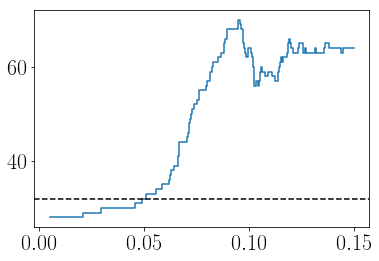

In [12]:
plt.step(arr_DiffLens, arr_Npeaks)
plt.axhline(y=32,ls='--',color='k')

In [17]:
len(arr_depth)

291

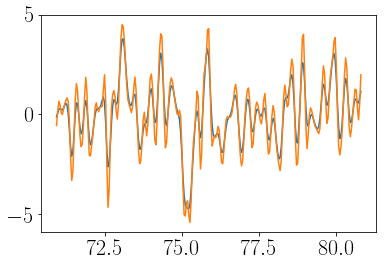

In [21]:
plt.plot(arr_depth[0], arr_data[0])
plt.plot(arr_depth[100], arr_data[100])

In [32]:
peaks

array([  2,   6,  10,  14,  18,  22,  26,  30,  34,  38,  42,  46,  50,
        54,  58,  62,  66,  70,  74,  78,  82,  86,  90,  94,  98, 102,
       106, 110, 114, 118, 122, 126, 130, 134, 138, 143, 147, 151, 155,
       159, 163, 167, 171, 175, 179, 183, 187, 191, 195, 199, 203, 207,
       211, 215, 219, 224, 228, 232, 236, 240, 244, 249, 253, 257])

0.04500000000000003


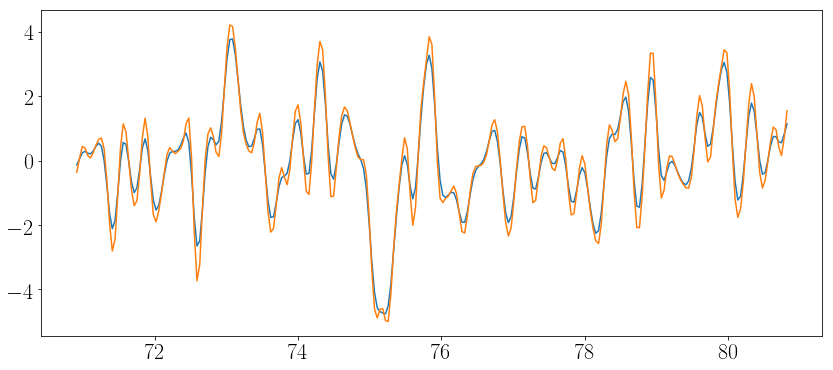

In [31]:
fig, ax = plt.subplots(figsize=(14,6))
i=80
print(arr_DiffLens[i])
plt.plot(arr_depth[0],arr_data[0])
plt.plot(arr_depth[i], arr_data[i])